## Project 1 - Collaborative Filtering

### ETH Computational Intelligence Lab 2021 - Project 1 

Disclaimer: Most methods mentioned here are briefly presented and not optimized. A solid baseline comparison may explore ways to optimize these. 

The problem of collaborative filtering concerns providing users with personalized product recommendations. The growth of e-commerce and social media platforms has established the need for recommender systems capable of providing personalized product recommendations. Here we resolve to past user behavior and exploit data dependencies to predict preferences for specific user-item interactions. 

This problem attracted great interest by the introduction of the [Netflix Prize](https://www.netflixprize.com/) that aimed to improve recommendations of Netflix's own algorithm. Given a list of users-items interactions, the task is to predict a series of ratings for another list of future interactions.

In our setting, we are dealing with a smaller dataset. 

We are given a set of $N = 1,176,952$ integer movie ratings, ranging from $1$ to $5$, that are assigned by $m=10,000$ users to $n=1,000$ movies. A rating $r_{ui}$ indicates the preference by user $u$ of item $i$. Let $\mathcal{\Omega} = \{(u,i) : r_{ui} \text{ is known} \}$ be the set of user and movie indices for which the ratings are known. 

In [1]:
#@title Basic Imports

import pandas as pd
import numpy as np
import math

To download the data make sure you have joined the kaggle competition. Then create an api key through kaggle.

In [2]:
number_of_users, number_of_movies = (10000, 1000)

data_pd = pd.read_csv('../data/data_train.csv')
print(data_pd.head(5))
print()
print('Shape', data_pd.shape)

       Id  Prediction
0  r44_c1           4
1  r61_c1           3
2  r67_c1           4
3  r72_c1           3
4  r86_c1           5

Shape (1176952, 2)


The provided data $\mathcal{\Omega}$ are split into two disjoint subsets, namely $\mathcal{\Omega}_{\text{train}}$ and $\mathcal{\Omega}_{\text{test}}$. The former consists of $90\%$ of the data and is used for training the individual models whereas the latter consists of the remaining $10\%$ of the data and is used for learning optimal blending weights. Depending on your method, you may choose to retrain on the whole dataset for the final solution.

In [3]:
from sklearn.model_selection import train_test_split
# Split the dataset into train and test

train_size = 0.9

train_pd, test_pd = train_test_split(data_pd, train_size=train_size, random_state=42)

Preprocess data by creating a $m \times n$ matrix

$$A_{ui} = \begin{cases} 
      r_{ui} & \text{ if } (u,i) \in \mathcal{\Omega}_{\text{train}} \\
      0 & \text{ else }
\end{cases}.$$

In [4]:
def extract_users_items_predictions(data_pd):
    users, movies = \
        [np.squeeze(arr) for arr in np.split(data_pd.Id.str.extract('r(\d+)_c(\d+)').values.astype(int) - 1, 2, axis=-1)]
    predictions = data_pd.Prediction.values
    return users, movies, predictions

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

# also create full matrix of observed values
data = np.full((number_of_users, number_of_movies), np.mean(train_pd.Prediction.values))
mask = np.zeros((number_of_users, number_of_movies)) # 0 -> unobserved value, 1->observed value

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

To consider:
* Do unobserved values matter for the method we are using? If yes, is the above initialization the best?
* Does normalization of the data matter for the method we are using?
* If yes, should we do the same transformations for the test data?

Our task is to predict ratings according to specific users-movies combinations. We will quantify the quality of our predictions based on the root mean squared error (RMSE) function between the true and observed ratings. For a given set of observations $ \mathcal{\Omega}$, let
\begin{equation}
    \text{RMSE} = \sqrt{\frac{1}{|\mathcal{\Omega}|}\sum_{ (u,i) \in \mathcal{\Omega}} \big(r_{ui} - \hat{r}_{ui}\big)^2}
\end{equation}
where $\hat{r}_{ui}$ denotes the estimate of $r_{ui}$.

In [7]:
from sklearn.metrics import mean_squared_error

rmse = lambda x, y: math.sqrt(mean_squared_error(x, y))

test_users, test_movies, test_predictions = extract_users_items_predictions(test_pd)

# test our predictions with the true values
def get_score(predictions, target_values=test_predictions):
    return rmse(predictions, target_values)

def extract_prediction_from_full_matrix(reconstructed_matrix, users=test_users, movies=test_movies):
    # returns predictions for the users-movies combinations specified based on a full m \times n matrix
    assert(len(users) == len(movies)), "users-movies combinations specified should have equal length"
    predictions = np.zeros(len(test_users))

    for i, (user, movie) in enumerate(zip(users, movies)):
        predictions[i] = reconstructed_matrix[user][movie]

    return predictions

# Methods and Approaches

## General Average

In [8]:
train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

# also create full matrix of observed values
data = np.full((number_of_users, number_of_movies), np.mean(train_pd.Prediction.values))

reconstructed_matrix = data

predictions = extract_prediction_from_full_matrix(reconstructed_matrix)

print("RMSE: {:.4f}".format(get_score(predictions)))

RMSE: 1.1200


## User Average

In [7]:
train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

def calculate_user_means(train_users, train_predictions):
    train_user_predictions_mapping = {}
    for train_user, train_prediction in zip(train_users, train_predictions):
        if train_user in train_user_predictions_mapping.keys():
            train_user_predictions_mapping[train_user].append(train_prediction)
        else:
            train_user_predictions_mapping[train_user] = [train_prediction]
    train_user_prediction_mean_mapping = {}
    for key, value in train_user_predictions_mapping.items():
        train_user_prediction_mean_mapping[key] = np.mean(value)
    return train_user_prediction_mean_mapping

data = np.full((number_of_users, number_of_movies), 0)

train_user_prediction_mean_mapping = calculate_user_means(train_users, train_predictions)

for user, movie in zip(test_users.tolist(), test_movies.tolist()):
    data[user][movie] = train_user_prediction_mean_mapping[user]

reconstructed_matrix = data

predictions = extract_prediction_from_full_matrix(reconstructed_matrix)

print("RMSE: {:.4f}".format(get_score(predictions)))

RMSE: 1.2675


## Movie Average

In [8]:
train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

def calculate_movie_means(train_movies, train_predictions):
    train_movie_predictions_mapping = {}
    for train_movie, train_prediction in zip(train_movies, train_predictions):
        if train_movie in train_movie_predictions_mapping.keys():
            train_movie_predictions_mapping[train_movie].append(train_prediction)
        else:
            train_movie_predictions_mapping[train_movie] = [train_prediction]
    train_movie_prediction_mean_mapping = {}
    for key, value in train_movie_predictions_mapping.items():
        train_movie_prediction_mean_mapping[key] = np.mean(value)
    return train_movie_prediction_mean_mapping

# also create full matrix of observed values
data = np.full((number_of_users, number_of_movies), 0)

train_movie_prediction_mean_mapping = calculate_movie_means(train_movies, train_predictions)

for user, movie in zip(test_users.tolist(), test_movies.tolist()):
    data[user][movie] = train_user_prediction_mean_mapping[movie]

reconstructed_matrix = data

predictions = extract_prediction_from_full_matrix(reconstructed_matrix)

print("RMSE: {:.4f}".format(get_score(predictions)))

RMSE: 1.3312


## Singular Value Decomposition (SVD)

Assuming that column entries are not random, we attempt to fill the missing entries by capturing some of the most significant components of the underlying data. Assume that a latent factor model associates each user $u$ with a set of user factors $ p_u \in \mathbb{R}^k$ and each item $i$ with a set of item factors $ q_i \in \mathbb{R}^k$. In the case of movies, some of these factors could correspond to movie genres such as comedy, drama, action etc. For each item $i$, the elements of $ q_i$ quantify the extent to which the item possesses these factors. Similarly, for each user $u$, the elements of $ p_u$ measure the level of interest that the user has to each of these factors. In this framework, user-item interactions are modeled by inner products in the latent space, leading to the following prediction rule 
\begin{equation}
\hat{r}_{ui} =  p_u^T q_i.
\end{equation}

Singular Value Decomposition (SVD) [1] is a widely used technique for matrix factorization. Any matrix $ M \in \mathbb{R}^{m \times n}$ can be decomposed into $A = U \Sigma V^T$, where $ U \in \mathbb{R}^{m\times m}$, $ \Sigma \in \mathbb{R}^{m \times n}$ and $ V \in \mathbb{R}^{n \times n}$. Matrices $ U$ and $ V$ are orthogonal, whereas $ \Sigma$ has $ rank(A)$ positive entries on the main diagonal sorted in decreasing order of value. 

We apply the SVD on the imputed user-item matrix to decompose it into $A =  U  \Sigma  V^T$. We may assume that a list of $k$ distinguishes users' interests and movies' characteristics. This motivates us to approximate $A$ by another matrix of low rank. The Eckart-Young theorem [2] states that the optimal (in terms of the Frobenius norm objective) rank $k$ approximation of the matrix $A$ is given by $A_k =  U_k  \Sigma_k  V^T_k$, where $ U_k \in \mathbb{R}^{m \times k}$, $ \Sigma_k \in \mathbb{R}^{k \times k}$ and $ V_k \in \mathbb{R}^{n \times k}$. $ U_k$ and $ V_k$ correspond to the first $k$ columns of $ U$ and $ V$ respectively and $ \Sigma_k$ to the $k \times k$ sub-matrix of $ \Sigma$ containing the $k$ largest singular values. 

----------------
[1] Klema, Virginia, and Alan Laub. "The singular value decomposition: Its computation and some applications." IEEE Transactions on automatic control 25.2 (1980): 164-176.

[2] Eckart, Carl, and Gale Young. "The approximation of one matrix by another of lower rank." Psychometrika 1.3 (1936): 211-218.

How many singular values should we keep? Try them all!
This is why we first use a train-validation split.

## Vanilla SVD

In [11]:
train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

data = np.full((number_of_users, number_of_movies), np.mean(train_pd.Prediction.values))
mask = np.zeros((number_of_users, number_of_movies)) # 0 -> unobserved value, 1->observed value

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

k_singular_values = 10
number_of_singular_values = min(number_of_users, number_of_movies)

assert(k_singular_values <= number_of_singular_values), "choose correct number of singular values"

U, s, Vt = np.linalg.svd(data, full_matrices=False)

S = np.zeros((number_of_movies, number_of_movies))
S[:k_singular_values, :k_singular_values] = np.diag(s[:k_singular_values])

reconstructed_matrix = U.dot(S).dot(Vt)
    
predictions = extract_prediction_from_full_matrix(reconstructed_matrix)

print("RMSE using SVD is: {:.4f}".format(get_score(predictions)))

RMSE using SVD is: 1.0657


## SVD with user-based standardization

In [12]:
train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

def standardize_train_predictions(train_users, train_predictions):
    train_user_predictions_mapping = {}
    for train_user, train_prediction in zip(train_users, train_predictions):
        if train_user in train_user_predictions_mapping.keys():
            train_user_predictions_mapping[train_user].append(train_prediction)
        else:
            train_user_predictions_mapping[train_user] = [train_prediction]

    train_user_prediction_mean_mapping = {}
    train_user_prediction_std_mapping = {}
    for key, value in train_user_predictions_mapping.items():
        train_user_prediction_mean_mapping[key] = np.mean(value)
        train_user_prediction_std_mapping[key] = np.std(value)

    df = pd.DataFrame.from_dict({"train_user": train_users, "train_predictions": train_predictions})
    df["train_predictions"] = df.apply(lambda x: (x["train_predictions"] - train_user_prediction_mean_mapping[x["train_user"]]) / train_user_prediction_std_mapping[x["train_user"]], axis=1)
    return df["train_predictions"].values, train_user_prediction_mean_mapping, train_user_prediction_std_mapping

def unstandardize_test_predictions(test_users, test_predictions, train_user_prediction_mean_mapping, train_user_prediction_std_mapping):
    df = pd.DataFrame.from_dict({"test_user": test_users, "test_predictions": test_predictions})
    df["test_predictions"] = df.apply(lambda x: (x["test_predictions"] * train_user_prediction_std_mapping[x["test_user"]]) + train_user_prediction_mean_mapping[x["test_user"]], axis=1)
    return df["test_predictions"].values

standardized_train_predictions, train_user_prediction_mean_mapping, train_user_prediction_std_mapping = standardize_train_predictions(train_users, train_predictions)

unstandardized_train_predictions = unstandardize_test_predictions(train_users, standardized_train_predictions, train_user_prediction_mean_mapping, train_user_prediction_std_mapping)

assert np.allclose(unstandardized_train_predictions, train_predictions), "Unstandardized train predictions are different than original train predictions"

data = np.full((number_of_users, number_of_movies), 0)
mask = np.zeros((number_of_users, number_of_movies)) # 0 -> unobserved value, 1->observed value

for user, movie, pred in zip(train_users, train_movies, standardized_train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

k_singular_values = 10
number_of_singular_values = min(number_of_users, number_of_movies)

assert(k_singular_values <= number_of_singular_values), "choose correct number of singular values"

U, s, Vt = np.linalg.svd(data, full_matrices=False)

S = np.zeros((number_of_movies, number_of_movies))
S[:k_singular_values, :k_singular_values] = np.diag(s[:k_singular_values])

reconstructed_matrix = U.dot(S).dot(Vt)

standardized_test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
unstandardized_test_predictions = unstandardize_test_predictions(test_users, standardized_test_predictions, train_user_prediction_mean_mapping, train_user_prediction_std_mapping)

print("RMSE: {:.4f}".format(get_score(unstandardized_test_predictions)))


RMSE: 1.0726


## SVD with movie based standardization

In [13]:
train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

def standardize_train_predictions(train_movies, train_predictions):
    train_movie_predictions_mapping = {}
    for train_movie, train_prediction in zip(train_movies, train_predictions):
        if train_movie in train_movie_predictions_mapping.keys():
            train_movie_predictions_mapping[train_movie].append(train_prediction)
        else:
            train_movie_predictions_mapping[train_movie] = [train_prediction]

    train_movie_prediction_mean_mapping = {}
    train_movie_prediction_std_mapping = {}
    for key, value in train_movie_predictions_mapping.items():
        train_movie_prediction_mean_mapping[key] = np.mean(value)
        train_movie_prediction_std_mapping[key] = np.std(value)

    df = pd.DataFrame.from_dict({"train_movie": train_movies, "train_predictions": train_predictions})
    df["train_predictions"] = df.apply(lambda x: (x["train_predictions"] - train_movie_prediction_mean_mapping[x["train_movie"]]) / train_movie_prediction_std_mapping[x["train_movie"]], axis=1)
    return df["train_predictions"].values, train_movie_prediction_mean_mapping, train_movie_prediction_std_mapping

def unstandardize_test_predictions(test_movies, test_predictions, train_movie_prediction_mean_mapping, train_movie_prediction_std_mapping):
    df = pd.DataFrame.from_dict({"test_movie": test_movies, "test_predictions": test_predictions})
    df["test_predictions"] = df.apply(lambda x: (x["test_predictions"] * train_movie_prediction_std_mapping[x["test_movie"]]) + train_movie_prediction_mean_mapping[x["test_movie"]], axis=1)
    return df["test_predictions"].values

standardized_train_predictions, train_movie_prediction_mean_mapping, train_movie_prediction_std_mapping = standardize_train_predictions(train_movies, train_predictions)

unstandardized_train_predictions = unstandardize_test_predictions(train_movies, standardized_train_predictions, train_movie_prediction_mean_mapping, train_movie_prediction_std_mapping)

assert np.allclose(unstandardized_train_predictions, train_predictions), "Unstandardized train predictions are different than original train predictions"

data = np.full((number_of_users, number_of_movies), 0)
mask = np.zeros((number_of_users, number_of_movies)) # 0 -> unobserved value, 1->observed value

for user, movie, pred in zip(train_users, train_movies, standardized_train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

k_singular_values = 10
number_of_singular_values = min(number_of_users, number_of_movies)

assert(k_singular_values <= number_of_singular_values), "choose correct number of singular values"

U, s, Vt = np.linalg.svd(data, full_matrices=False)

S = np.zeros((number_of_movies, number_of_movies))
S[:k_singular_values, :k_singular_values] = np.diag(s[:k_singular_values])

reconstructed_matrix = U.dot(S).dot(Vt)

standardized_test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
unstandardized_test_predictions = unstandardize_test_predictions(test_movies, standardized_test_predictions, train_movie_prediction_mean_mapping, train_movie_prediction_std_mapping)

print("RMSE: {:.4f}".format(get_score(unstandardized_test_predictions)))


RMSE: 1.0237


To consider:
* How can we improve SVD? As aforementioned initialization of unobserved values matters for SVD.
* Can we use SVD iteratively to better initialize unobserved values?
* Maybe start from a low-rank reconstruction and after you have ensured better initialization increase the reconstruction rank.
* Can we make adjustments to SVD? Other variations exist, see e.g. [1, 2], Singular Value Projection, Nuclear Norm Relaxation ...
 
--------------
[1] Cai, Jian-Feng, Emmanuel J. Candès, and Zuowei Shen. "A singular value thresholding algorithm for matrix completion." SIAM Journal on optimization 20.4 (2010): 1956-1982.
 
[2] Zarmehi, Nematollah, and Farokh Marvasti. "Adaptive singular value thresholding." 2017 International Conference on Sampling Theory and Applications (SampTA). IEEE, 2017.


## Alternating Least Squares (ALS)
 
SVD is very sensitive to initialization. Can we propose a method that defines a loss function only on the user-items interactions observed and not the whole matrix? Regularizing the weights also improves stability and ensures simpler solutions in accordance with [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor).
 
Can we propose a method that defines a loss function only on the user-items interactions observed? 

Our new objective is to minimize the following loss-function
\begin{equation}
\sum\limits_{(u,i) \in \mathcal{\Omega}_{\text{train}}}(r_{ui} - p_u^T q_i)^2 + \lambda\sum_{u=1}^m\| p_u\|^2 + \lambda\sum\limits_{i=1}^n \| q_i\|^2,
\end{equation}
where $\lambda$ denotes a tunable regularization parameter.
 
How can we optimize this objective? In general it is a non-convex problem. Optimize using stochastic gradient descent.
 
 
--------------
[1] Koren, Yehuda, Robert Bell, and Chris Volinsky. "Matrix factorization techniques for recommender systems." Computer 42.8 (2009): 30-37.
 

## ALS

In [34]:
from tqdm import tqdm

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

data = np.full((number_of_users, number_of_movies), 0)
mask = np.zeros((number_of_users, number_of_movies))

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

# for k in [2, 5, 10, 25, 50, 100, 200, 500, 900]:
#     for lmbd in [2e-5, 2e-3, 2e-1, 2, 200]:
#         print(f"k: {k}, lmbd: {lmdb}")

k = 10
lmbd = 0.2
lr = 0.5

epochs = 5
U = np.random.normal(loc=0.2, scale=0.2, size=(number_of_users, k))
V = np.random.normal(loc=0.2, scale=0.2, size=(k, number_of_movies))

# without sgd
for epoch in range(epochs):
    reconstructed_matrix = U.dot(V)
    test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
    print(f"Epoch: {epoch} RMSE: {get_score(test_predictions)}")
    for i in tqdm(list(range(number_of_users))):
        rated_movie_indices = np.argwhere(mask[i, :] == 1).ravel()
        left = lmbd * np.eye(k)
        right = np.zeros((k, 1))
        for j in rated_movie_indices:
            vj = V[:, j].reshape(-1, 1)
            left += vj.dot(vj.T)
            right += data[i, j] * vj
        U[i, :] = np.linalg.inv(left).dot(right).ravel()
    for j in tqdm(list(range(number_of_movies))):
        rater_user_indices = np.argwhere(mask[:, j] == 1).ravel()
        left = lmbd * np.eye(k)
        right = np.zeros((k, 1))
        for i in rater_user_indices:
            ui = U[i, :].reshape(-1, 1)
            left += ui.dot(ui.T)
            right += data[i, j] * ui
        V[:, j] = np.linalg.inv(left).dot(right).ravel()


# with sgd v1
# for epoch in range(epochs):
#     reconstructed_matrix = U.dot(V)
#     test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
#     print(f"Epoch: {epoch} RMSE: {get_score(test_predictions)}")
#     for i in tqdm(list(range(number_of_users))):
#         rated_movie_indices = np.argwhere(mask[i, :] == 1).ravel()
#         left = lmbd * np.eye(k)
#         right = np.zeros((k, 1))
#         for j in rated_movie_indices:
#             vj = V[:, j].reshape(-1, 1)
#             left += vj.dot(vj.T)
#             right += data[i, j] * vj
#         U[i, :] = (1 - lr) * U[i, :] + lr * np.linalg.inv(left).dot(right).ravel()
#     for j in tqdm(list(range(number_of_movies))):
#         rater_user_indices = np.argwhere(mask[:, j] == 1).ravel()
#         left = lmbd * np.eye(k)
#         right = np.zeros((k, 1))
#         for i in rater_user_indices:
#             ui = U[i, :].reshape(-1, 1)
#             left += ui.dot(ui.T)
#             right += data[i, j] * ui
#         V[:, j] = (1 - lr) * V[:, j] + lr * np.linalg.inv(left).dot(right).ravel()


# with sgd v2
# for epoch in range(epochs):
#     if epoch % 100 == 0:
#         reconstructed_matrix = U.dot(V)
#         test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
#         print(f"Epoch: {epoch} RMSE: {get_score(test_predictions)}")
#     
#     if np.random.random() > 0.9:
#         i = np.random.randint(low=0, high=U.shape[0])
#         rated_movie_indices = np.argwhere(mask[i, :] == 1).ravel()
#         ui = U[i, :].reshape(-1, 1)
#         left = lmbd * np.eye(k)
#         right = np.zeros((k, 1))
#         for j in rated_movie_indices:
#             vj = V[:, j].reshape(-1, 1)
#             left += vj.dot(vj.T)
#             right += data[i, j] * vj
#         U[i, :] -= lr * (left.dot(ui) - right).ravel()
#     else:
#         j = np.random.randint(low=0, high=V.shape[1])
#         rater_user_indices = np.argwhere(mask[:, j] == 1).ravel()
#         vj = V[:, j].reshape(-1, 1)
#         left = lmbd * np.eye(k)
#         right = np.zeros((k, 1))
#         for i in rater_user_indices:
#             ui = U[i, :].reshape(-1, 1)
#             left += ui.dot(ui.T)
#             right += data[i, j] * ui
#         V[:, j] -= lr * (left.dot(vj) - right).ravel()


  1%|          | 68/10000 [00:00<00:14, 679.65it/s]

Epoch: 0 RMSE: 3.644720074160342


  1%|          | 67/10000 [00:00<00:14, 665.65it/s]

Epoch: 1 RMSE: 1.0413611987376221


  1%|          | 73/10000 [00:00<00:13, 725.20it/s]

Epoch: 2 RMSE: 1.0446876504569444


  1%|▏         | 140/10000 [00:00<00:14, 701.12it/s]

Epoch: 3 RMSE: 1.039942922642958


  1%|          | 73/10000 [00:00<00:13, 726.56it/s]

Epoch: 4 RMSE: 1.0369646620162045


100%|██████████| 1000/1000 [00:10<00:00, 99.65it/s]


# SGD

In [24]:
train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

data = np.full((number_of_users, number_of_movies), np.NaN)
mask = np.zeros((number_of_users, number_of_movies))

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

k = 96
lmbd = 0.02
lr = 0.001

epochs = 10000000000
U = np.random.normal(loc=0.2, scale=0.2, size=(number_of_users, k))
V = np.random.normal(loc=0.2, scale=0.2, size=(k, number_of_movies))

for epoch in range(epochs):
    if epoch % 1000000 == 0:
        reconstructed_matrix = U.dot(V)
        test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
        test_predictions = np.clip(test_predictions, 1, 5)
        print(f"Epoch: {epoch} RMSE: {get_score(test_predictions)}")    

    rand_i = np.random.randint(low=0, high=data.shape[0])
    rated_movies = np.argwhere(mask[rand_i, :] == 1).ravel()
    rand_j_idx = np.random.randint(low=0, high=len(rated_movies))
    rand_j = rated_movies[rand_j_idx]
    rand_k = np.random.randint(low=0, high=k)
    yijhat = U[rand_i, :].reshape(1, -1).dot(V[:, rand_j].reshape(-1, 1))
    yij = data[rand_i, rand_j]
    rij = yij - yijhat
    U[rand_i, rand_k] += lr * (rij * V[rand_k, rand_j] - lmbd * U[rand_i, rand_k])
    V[rand_k, rand_j] += lr * (rij * U[rand_i, rand_k] - lmbd * V[rand_k, rand_j])    


Epoch: 0 RMSE: 1.2983947777292975
Epoch: 1000000 RMSE: 1.2828230806834098
Epoch: 2000000 RMSE: 1.2699988049199753
Epoch: 3000000 RMSE: 1.2590684733709923
Epoch: 4000000 RMSE: 1.249863668167971
Epoch: 5000000 RMSE: 1.2419179494147836
Epoch: 6000000 RMSE: 1.235013800555504
Epoch: 7000000 RMSE: 1.2288946078709284
Epoch: 8000000 RMSE: 1.2234130203916367
Epoch: 9000000 RMSE: 1.2185490407504365
Epoch: 10000000 RMSE: 1.2141557179542324
Epoch: 11000000 RMSE: 1.2101641021899745
Epoch: 12000000 RMSE: 1.2064512652781751
Epoch: 13000000 RMSE: 1.2031019177186328
Epoch: 14000000 RMSE: 1.199939471991511
Epoch: 15000000 RMSE: 1.1969740364739037
Epoch: 16000000 RMSE: 1.194241623375147
Epoch: 17000000 RMSE: 1.1917293643929643
Epoch: 18000000 RMSE: 1.1893349859490998
Epoch: 19000000 RMSE: 1.1870720989517418
Epoch: 20000000 RMSE: 1.184954659853109
Epoch: 21000000 RMSE: 1.182881205745821
Epoch: 22000000 RMSE: 1.180953391801266
Epoch: 23000000 RMSE: 1.1791149448245648
Epoch: 24000000 RMSE: 1.17736444526853


Epoch: 200000000 RMSE: 1.076148836051612
Epoch: 201000000 RMSE: 1.0759195407981657
Epoch: 202000000 RMSE: 1.0756696491510451
Epoch: 203000000 RMSE: 1.0754167449772
Epoch: 204000000 RMSE: 1.0751811881411912
Epoch: 205000000 RMSE: 1.0749309050828422
Epoch: 206000000 RMSE: 1.0746946850454289
Epoch: 207000000 RMSE: 1.0744325011096088
Epoch: 208000000 RMSE: 1.0741715189448129
Epoch: 209000000 RMSE: 1.0739297405524981
Epoch: 210000000 RMSE: 1.0736698287278978
Epoch: 211000000 RMSE: 1.0734342132891246
Epoch: 212000000 RMSE: 1.0731813117233768
Epoch: 213000000 RMSE: 1.0729357527182974
Epoch: 214000000 RMSE: 1.072713001441781
Epoch: 215000000 RMSE: 1.0724921351280714
Epoch: 216000000 RMSE: 1.0722616391416453
Epoch: 217000000 RMSE: 1.0720043938204742
Epoch: 218000000 RMSE: 1.0717902744557342
Epoch: 219000000 RMSE: 1.071577178802869
Epoch: 220000000 RMSE: 1.0713649215444327
Epoch: 221000000 RMSE: 1.0711485243584784
Epoch: 222000000 RMSE: 1.070906573127162
Epoch: 223000000 RMSE: 1.0706483837463687

Epoch: 397000000 RMSE: 1.047144745769689
Epoch: 398000000 RMSE: 1.0470700010206564
Epoch: 399000000 RMSE: 1.0469934143814128
Epoch: 400000000 RMSE: 1.0469313970404504
Epoch: 401000000 RMSE: 1.0468708162519065
Epoch: 402000000 RMSE: 1.046781119545531
Epoch: 403000000 RMSE: 1.0467087487685776
Epoch: 404000000 RMSE: 1.0466587438951618
Epoch: 405000000 RMSE: 1.0465826285930577
Epoch: 406000000 RMSE: 1.0464981125563027
Epoch: 407000000 RMSE: 1.046424604775315
Epoch: 408000000 RMSE: 1.0463558406141666
Epoch: 409000000 RMSE: 1.046263928234367
Epoch: 410000000 RMSE: 1.0461772574414305
Epoch: 411000000 RMSE: 1.0460825399194356
Epoch: 412000000 RMSE: 1.0459994674262394
Epoch: 413000000 RMSE: 1.045950150332658
Epoch: 414000000 RMSE: 1.0458860281624167
Epoch: 415000000 RMSE: 1.045793162009117
Epoch: 416000000 RMSE: 1.0457058550196412
Epoch: 417000000 RMSE: 1.0456702321655678
Epoch: 418000000 RMSE: 1.0456105705864573
Epoch: 419000000 RMSE: 1.0455607432576814
Epoch: 420000000 RMSE: 1.045497899236226

Epoch: 594000000 RMSE: 1.0371856046357246
Epoch: 595000000 RMSE: 1.0371628109492799
Epoch: 596000000 RMSE: 1.0371192006784522
Epoch: 597000000 RMSE: 1.0370772235835977
Epoch: 598000000 RMSE: 1.0370260331287475
Epoch: 599000000 RMSE: 1.0369812818071882
Epoch: 600000000 RMSE: 1.0369577691107086
Epoch: 601000000 RMSE: 1.0369176998977974
Epoch: 602000000 RMSE: 1.036893424772928
Epoch: 603000000 RMSE: 1.0368513323916193
Epoch: 604000000 RMSE: 1.0368136562383024
Epoch: 605000000 RMSE: 1.0367935400899755
Epoch: 606000000 RMSE: 1.0367666898078285
Epoch: 607000000 RMSE: 1.0367448394514827
Epoch: 608000000 RMSE: 1.0367303602196551
Epoch: 609000000 RMSE: 1.0366660685685185
Epoch: 610000000 RMSE: 1.0366371397756087
Epoch: 611000000 RMSE: 1.036611497140289
Epoch: 612000000 RMSE: 1.0365752868716325
Epoch: 613000000 RMSE: 1.0365449053608562
Epoch: 614000000 RMSE: 1.0365220757767295
Epoch: 615000000 RMSE: 1.0364689546996035
Epoch: 616000000 RMSE: 1.0364404541308758
Epoch: 617000000 RMSE: 1.03642192855

Epoch: 791000000 RMSE: 1.0325470876042535
Epoch: 792000000 RMSE: 1.0325316501254207
Epoch: 793000000 RMSE: 1.0325114823599826
Epoch: 794000000 RMSE: 1.0324768842251815
Epoch: 795000000 RMSE: 1.0324553579901472
Epoch: 796000000 RMSE: 1.0324299541344395
Epoch: 797000000 RMSE: 1.0324086109640376
Epoch: 798000000 RMSE: 1.0323946578682943
Epoch: 799000000 RMSE: 1.0323607572493423
Epoch: 800000000 RMSE: 1.032338210507691
Epoch: 801000000 RMSE: 1.0323267238551495
Epoch: 802000000 RMSE: 1.032303858084374
Epoch: 803000000 RMSE: 1.0322809432618352
Epoch: 804000000 RMSE: 1.032289933466644
Epoch: 805000000 RMSE: 1.0322705970744182
Epoch: 806000000 RMSE: 1.0322585120763885
Epoch: 807000000 RMSE: 1.032262295338257
Epoch: 808000000 RMSE: 1.0322624787277415
Epoch: 809000000 RMSE: 1.0322416033440631
Epoch: 810000000 RMSE: 1.0322163421462212
Epoch: 811000000 RMSE: 1.0322093172895064
Epoch: 812000000 RMSE: 1.0321849368446168
Epoch: 813000000 RMSE: 1.0321719852289633
Epoch: 814000000 RMSE: 1.0321545412425

Epoch: 987000000 RMSE: 1.0301519726227129
Epoch: 988000000 RMSE: 1.0301455821324665
Epoch: 989000000 RMSE: 1.0301311792015186
Epoch: 990000000 RMSE: 1.0301124919850526
Epoch: 991000000 RMSE: 1.0301079328875697
Epoch: 992000000 RMSE: 1.0301181599102789
Epoch: 993000000 RMSE: 1.030114678056165
Epoch: 994000000 RMSE: 1.0300867812108536
Epoch: 995000000 RMSE: 1.0300800726394028
Epoch: 996000000 RMSE: 1.0300873074737977
Epoch: 997000000 RMSE: 1.030078625263732
Epoch: 998000000 RMSE: 1.0300628810428958
Epoch: 999000000 RMSE: 1.0300506461424295
Epoch: 1000000000 RMSE: 1.0300316011461759
Epoch: 1001000000 RMSE: 1.0300118805912877
Epoch: 1002000000 RMSE: 1.030005902966834
Epoch: 1003000000 RMSE: 1.0299919069603405
Epoch: 1004000000 RMSE: 1.0299787439051733
Epoch: 1005000000 RMSE: 1.0299760930778104
Epoch: 1006000000 RMSE: 1.0299613711301656
Epoch: 1007000000 RMSE: 1.0299472414973374
Epoch: 1008000000 RMSE: 1.0299383272879932
Epoch: 1009000000 RMSE: 1.0299196731958427
Epoch: 1010000000 RMSE: 1.0

Epoch: 1179000000 RMSE: 1.028725522514689
Epoch: 1180000000 RMSE: 1.028737642068654
Epoch: 1181000000 RMSE: 1.0287172439812151
Epoch: 1182000000 RMSE: 1.0286995458235362
Epoch: 1183000000 RMSE: 1.0286932960328605
Epoch: 1184000000 RMSE: 1.0286917064051109
Epoch: 1185000000 RMSE: 1.028670248225917
Epoch: 1186000000 RMSE: 1.0286695597658206
Epoch: 1187000000 RMSE: 1.0286519113846722
Epoch: 1188000000 RMSE: 1.0286327957276833
Epoch: 1189000000 RMSE: 1.0286290157290605
Epoch: 1190000000 RMSE: 1.028621761578239
Epoch: 1191000000 RMSE: 1.0286156694032693
Epoch: 1192000000 RMSE: 1.0286252118535748
Epoch: 1193000000 RMSE: 1.0286124152219092
Epoch: 1194000000 RMSE: 1.0286051342566296
Epoch: 1195000000 RMSE: 1.028620777205536
Epoch: 1196000000 RMSE: 1.0286042747506288


KeyboardInterrupt: 

# BASIC

In [16]:
from tqdm import tqdm
from scipy.sparse import csr_matrix
from lightgbm import LGBMRegressor

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

data = np.full((number_of_users, number_of_movies), np.NaN)
mask = np.zeros((number_of_users, number_of_movies))

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

user_predictors = []
for i in range(data.shape[0]):
    current_user_data = data[i, :].ravel()
    emp_prob_1 = current_user_data[current_user_data == 1].shape[0] / current_user_data.shape[0]
    emp_prob_2 = current_user_data[current_user_data == 2].shape[0] / current_user_data.shape[0]
    emp_prob_3 = current_user_data[current_user_data == 3].shape[0] / current_user_data.shape[0]
    emp_prob_4 = current_user_data[current_user_data == 4].shape[0] / current_user_data.shape[0]
    emp_prob_5 = current_user_data[current_user_data == 5].shape[0] / current_user_data.shape[0]
    user_predictors.append([emp_prob_1, emp_prob_2, emp_prob_3, emp_prob_4, emp_prob_5])
user_predictors = np.array(user_predictors)

data_normalized = data - np.nanmean(data, axis=1).reshape(-1, 1)
movie_predictors = []
for j in range(data_normalized.shape[1]):
    current_movie_data = data_normalized[:, j].ravel()
    movie_predictors.append(np.nanmean(current_movie_data))
movie_predictors = np.array(movie_predictors)

lr_train_data = []
lr_test_data = []
lr_test_data_row_indices = []
lr_test_data_col_indices = []
for i in tqdm(list(range(user_predictors.shape[0]))):
    for j in range(movie_predictors.shape[0]):
        if np.isnan(data[i, j]):
            lr_test_data.append(np.hstack((user_predictors[i, :], movie_predictors[j])))
            lr_test_data_row_indices.append(i)
            lr_test_data_col_indices.append(j)
        else:
            lr_train_data.append(np.hstack((user_predictors[i, :], movie_predictors[j], data[i, j])))
lr_train_data = np.array(lr_train_data)
lr_test_data = np.array(lr_test_data)
lr_test_data_row_indices = np.array(lr_test_data_row_indices)
lr_test_data_col_indices = np.array(lr_test_data_col_indices)

train_X = lr_train_data[:, :6]
train_y = lr_train_data[:, 6].ravel()
test_X = lr_test_data
model = LGBMRegressor()
model.fit(train_X, train_y)
predictions = np.clip(model.predict(test_X), 1, 5)
reconstructed_matrix = csr_matrix((predictions, (lr_test_data_row_indices, lr_test_data_col_indices))).toarray()
test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
print(f"RMSE: {get_score(test_predictions)}")


100%|██████████| 10000/10000 [02:18<00:00, 72.05it/s]


RMSE: 0.9984378057749016


# BASIC + RSVD

In [59]:
from tqdm import tqdm
from scipy.sparse import csr_matrix
# from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

data = np.full((number_of_users, number_of_movies), np.NaN)
mask = np.zeros((number_of_users, number_of_movies))

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

user_predictors = []
for i in range(data.shape[0]):
    current_user_data = data[i, :].ravel()
    emp_prob_1 = current_user_data[current_user_data == 1].shape[0] / current_user_data.shape[0]
    emp_prob_2 = current_user_data[current_user_data == 2].shape[0] / current_user_data.shape[0]
    emp_prob_3 = current_user_data[current_user_data == 3].shape[0] / current_user_data.shape[0]
    emp_prob_4 = current_user_data[current_user_data == 4].shape[0] / current_user_data.shape[0]
    emp_prob_5 = current_user_data[current_user_data == 5].shape[0] / current_user_data.shape[0]
    user_predictors.append([emp_prob_1, emp_prob_2, emp_prob_3, emp_prob_4, emp_prob_5])
user_predictors = np.array(user_predictors)

data_normalized = data - np.nanmean(data, axis=1).reshape(-1, 1)
movie_predictors = []
for j in range(data_normalized.shape[1]):
    current_movie_data = data_normalized[:, j].ravel()
    movie_predictors.append(np.nanmean(current_movie_data))
movie_predictors = np.array(movie_predictors)

lr_train_data = []
lr_test_data = []
lr_test_data_row_indices = []
lr_test_data_col_indices = []
for i in tqdm(list(range(user_predictors.shape[0]))):
    for j in range(movie_predictors.shape[0]):
        lr_test_data.append(np.hstack((user_predictors[i, :], movie_predictors[j])))
        lr_test_data_row_indices.append(i)
        lr_test_data_col_indices.append(j)
        if np.isnan(data[i, j]):
            continue
        else:
            lr_train_data.append(np.hstack((user_predictors[i, :], movie_predictors[j], data[i, j])))
lr_train_data = np.array(lr_train_data)
lr_test_data = np.array(lr_test_data)
lr_test_data_row_indices = np.array(lr_test_data_row_indices)
lr_test_data_col_indices = np.array(lr_test_data_col_indices)

train_X = lr_train_data[:, :6]
train_y = lr_train_data[:, 6].ravel()
test_X = lr_test_data
model = LinearRegression()
model.fit(train_X, train_y)
predictions = np.clip(model.predict(test_X), 1, 5)
reconstructed_matrix_basic = csr_matrix((predictions, (lr_test_data_row_indices, lr_test_data_col_indices))).toarray()

data = data - reconstructed_matrix_basic


100%|██████████| 10000/10000 [02:20<00:00, 71.43it/s]


In [60]:
epochs = 100000000
lr = 0.001
lmbd = 0.02
k = 96

data[mask == 0] = 0
U, s, V = np.linalg.svd(data)
U = U[:, :96]
s = s[:96]
V = V[:96, :]
S = np.diag(s)
U = U.dot(np.sqrt(S))
V = np.sqrt(S).dot(V)

# U = np.random.normal(loc=0.2, scale=0.2, size=(number_of_users, k))
# V = np.random.normal(loc=0.2, scale=0.2, size=(k, number_of_movies))

for epoch in range(epochs):
    if epoch % 1000000 == 0:
        reconstructed_matrix_rsvd = U.dot(V)
        test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix_rsvd + reconstructed_matrix_basic)
        test_predictions = np.clip(test_predictions, 1, 5)
        print(f"Epoch: {epoch} RMSE: {get_score(test_predictions)}")    

    rand_i = np.random.randint(low=0, high=data.shape[0])
    rated_movies = np.argwhere(mask[rand_i, :] == 1).ravel()
    rand_j_idx = np.random.randint(low=0, high=len(rated_movies))
    rand_j = rated_movies[rand_j_idx]
    rand_k = np.random.randint(low=0, high=k)
    yijhat = U[rand_i, :].reshape(1, -1).dot(V[:, rand_j].reshape(-1, 1))
    yij = data[rand_i, rand_j]
    rij = yij - yijhat
    U[rand_i, rand_k] += lr * (rij * V[rand_k, rand_j] - lmbd * U[rand_i, rand_k])
    V[rand_k, rand_j] += lr * (rij * U[rand_i, rand_k] - lmbd * V[rand_k, rand_j])


Epoch: 0 RMSE: 1.0016646979512493
Epoch: 1000000 RMSE: 1.001660772679242
Epoch: 2000000 RMSE: 1.001657510204613
Epoch: 3000000 RMSE: 1.0016550975247087
Epoch: 4000000 RMSE: 1.0016513752078418
Epoch: 5000000 RMSE: 1.001644717729854
Epoch: 6000000 RMSE: 1.0016436077660102
Epoch: 7000000 RMSE: 1.0016390980373366
Epoch: 8000000 RMSE: 1.0016360349631084
Epoch: 9000000 RMSE: 1.0016347545944624
Epoch: 10000000 RMSE: 1.0016284523885832
Epoch: 11000000 RMSE: 1.0016254864414382
Epoch: 12000000 RMSE: 1.001621566718368
Epoch: 13000000 RMSE: 1.0016194651508352
Epoch: 14000000 RMSE: 1.0016144903435515
Epoch: 15000000 RMSE: 1.00160739836946
Epoch: 16000000 RMSE: 1.001604569436229
Epoch: 17000000 RMSE: 1.0015992345117406
Epoch: 18000000 RMSE: 1.0015967753921802
Epoch: 19000000 RMSE: 1.0015923996532574
Epoch: 20000000 RMSE: 1.0015933174409148
Epoch: 21000000 RMSE: 1.0015873134198112
Epoch: 22000000 RMSE: 1.0015824355741512
Epoch: 23000000 RMSE: 1.0015783186574834
Epoch: 24000000 RMSE: 1.001576228376824

KeyboardInterrupt: 

## Improved SVD
 
Can we also include user-specific or movie-specific biases?
 
Compare to the simple SVD assumption
\begin{equation}
\hat{r}_{ui} =  p_u^T q_i,
\end{equation}
a more reasonable premise is [1]
\begin{equation}
r_{ui} = p_u^T q_i + b_u + b_i,
\end{equation}
where $b_u, b_i \in \mathbb{R}$, allowing to model a significant portion of the observed variation that comes from effects associated with either the user or the items.
 
This allows us to model more complex interactions. Optimization is done similarly to (ALS).
 
------------
[1] Paterek, Arkadiusz. "Improving regularized singular value decomposition for collaborative filtering." Proceedings of KDD cup and workshop. Vol. 2007. 2007.
 


In [10]:
from tqdm import tqdm

train_users, train_movies, train_predictions = extract_users_items_predictions(train_pd)

data = np.full((number_of_users, number_of_movies), 0)
mask = np.zeros((number_of_users, number_of_movies))

for user, movie, pred in zip(train_users, train_movies, train_predictions):
    data[user][movie] = pred
    mask[user][movie] = 1

k = 10
lmbd = 0.2
lr = 0.5

epochs = 5
U = np.random.normal(loc=0.2, scale=0.2, size=(number_of_users, k))
V = np.random.normal(loc=0.2, scale=0.2, size=(k, number_of_movies))
bu = np.random.normal(loc=0.2, scale=0.2, size=(number_of_users, 1))
bv = np.random.normal(loc=0.2, scale=0.2, size=(number_of_movies, 1))

# without sgd
for epoch in range(epochs):
    reconstructed_matrix = U.dot(V) + bu + bv.T
    test_predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
    print(f"Epoch: {epoch} RMSE: {get_score(test_predictions)}")
    
    for i in tqdm(list(range(number_of_users))):
        rated_movie_indices = np.argwhere(mask[i, :] == 1).ravel()
        bu_update = 0
        ui = U[i, :].reshape(-1, 1)
        for j in rated_movie_indices:
            vj = V[:, j].reshape(-1, 1)
            bu_update += data[i, j] - vj.T.dot(ui) - bv[j, 0]
        bu[i, :] = bu_update / len(rated_movie_indices)
    
    for j in tqdm(list(range(number_of_movies))):
        rater_user_indices = np.argwhere(mask[:, j] == 1).ravel()
        bv_update = 0
        vj = V[:, j].reshape(-1, 1)
        for i in rater_user_indices:
            ui = U[i, :].reshape(-1, 1)
            bv_update += data[i, j] - ui.T.dot(vj) - bu[i, 0]
        bv[j, :] = bv_update / len(rater_user_indices)
    
#     for i in tqdm(list(range(number_of_users))):
#         rated_movie_indices = np.argwhere(mask[i, :] == 1).ravel()
#         ui = U[i, :].reshape(-1, 1)
#         left = lmbd * np.eye(k)
#         right = np.zeros((k, 1))
#         for j in rated_movie_indices:
#             vj = V[:, j].reshape(-1, 1)
#             left += vj.dot(vj.T)
#             right += (data[i, j] - bu[i, 0] - bv[j, 0]) * vj
#         U[i, :] = np.linalg.inv(left).dot(right).ravel()
# 
#     for j in tqdm(list(range(number_of_movies))):
#         rater_user_indices = np.argwhere(mask[:, j] == 1).ravel()
#         vj = V[:, j].reshape(-1, 1)
#         left = lmbd * np.eye(k)
#         right = np.zeros((k, 1))
#         for i in rater_user_indices:
#             ui = U[i, :].reshape(-1, 1)
#             left += ui.dot(ui.T)
#             right += (data[i, j] - bu[i, 0] - bv[j, 0]) * ui 
#         V[:, j] = np.linalg.inv(left).dot(right).ravel()
    

  2%|▏         | 196/10000 [00:00<00:09, 989.86it/s]

Epoch: 0 RMSE: 3.2729175234325862


  1%|          | 103/10000 [00:00<00:09, 1020.97it/s]

Epoch: 1 RMSE: 1.014393820484168


  2%|▏         | 195/10000 [00:00<00:10, 976.05it/s]

Epoch: 2 RMSE: 1.0081646297045919


  1%|          | 100/10000 [00:00<00:09, 998.87it/s]

Epoch: 3 RMSE: 1.0081027926928607


  1%|          | 104/10000 [00:00<00:09, 1036.28it/s]

Epoch: 4 RMSE: 1.0081001121775193


100%|██████████| 1000/1000 [00:09<00:00, 100.32it/s]


Exercise:
- Implement ALS and Improved SVD and test its performance on the test dataset. Especially for large datasets, optimization via [Stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is chosen (more on this in later lectures). Derive the derivatives in terms of $p_u, q_i, b_u, b_i$ and choose a suitable learning rate (a specific value or decaying with time).

## Autoencoder
An autoencoder is a type of neural network that is used to learn efficient, low-dimensional data representations in an unsupervised manner [1]. It implements two transformations: first, the encoder $g_e : \mathbb{R}^d \rightarrow \mathbb{R}^k$ and secondly, the decoder $g_d : \mathbb{R}^k \rightarrow \mathbb{R}^d$, where $k < d$. The network is trained by minimizing the squared reconstruction loss between the input $ x$ and output $\hat{x} = g_d(g_e(x))$, thereafter learning an intermediate $k-$dimensional representation for $x$.

----------

[1] Hinton, Geoffrey E., and Ruslan R. Salakhutdinov. "Reducing the dimensionality of data with neural networks." science 313.5786 (2006): 504-507.


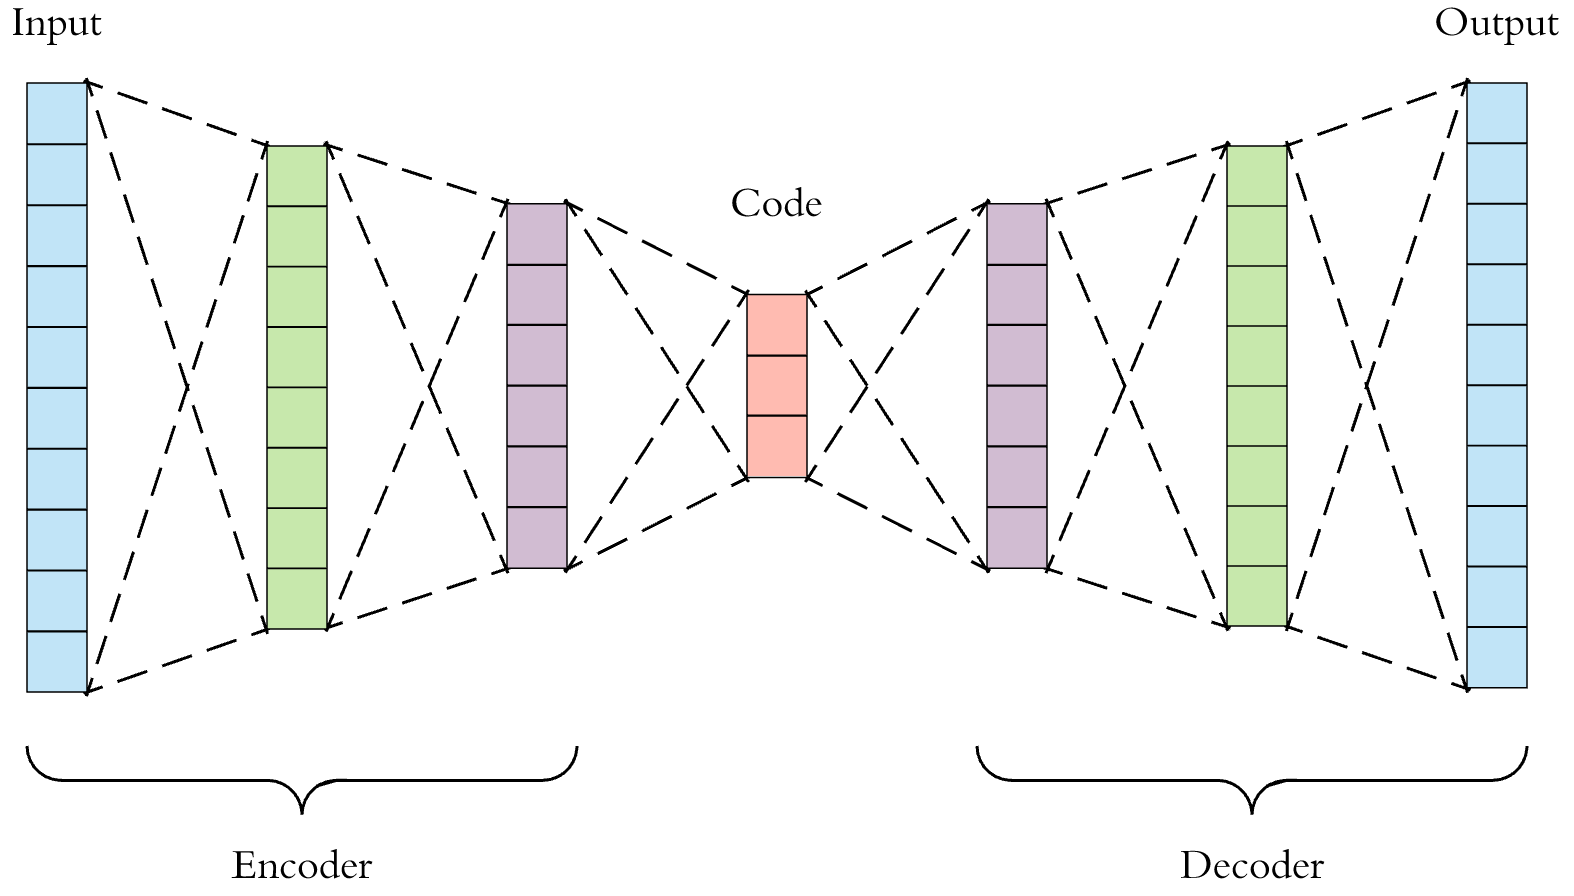

Similar to the SVD assumptions we may choose to use an autoencoder to learn the interactions. Deep autoencoders allow capruting of non-linear more complex interconnections. Autoencoders have proven to be very effective in the context of collaborative filtering [1, 2, 3]. Reconstruct for each user their 

------------
[1] Sedhain, Suvash, et al. "Autorec: Autoencoders meet collaborative filtering." Proceedings of the 24th international conference on World Wide Web. 2015.

[2] Strub, Florian, and Jeremie Mary. "Collaborative filtering with stacked denoising autoencoders and sparse inputs." NIPS workshop on machine learning for eCommerce. 2015.

[3] Kuchaiev, Oleksii, and Boris Ginsburg. "Training deep autoencoders for collaborative filtering." arXiv preprint arXiv:1708.01715 (2017).

In [9]:
#@title Use GPU in colab: Runtime->Change Runtime type
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cpu


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dimension, encoded_dimension=16):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=input_dimension, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=encoded_dimension),
            nn.ReLU()
        )
    
    def forward(self, data):
        return self.model(data)

class Decoder(nn.Module):
    def __init__(self, output_dimensions, encoded_dimension=16):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=encoded_dimension, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=output_dimensions),
            nn.ReLU() # How does the output look like? What about if you had first centered the data?!
        )
    
    def forward(self, encodings):
        return self.model(encodings)


class AutoEncoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, data):
        return self.decoder(self.encoder(data))

In [ ]:
# Parameters
batch_size = 64
num_epochs = 1000
show_validation_score_every_epochs = 5
encoded_dimension = 16
learning_rate = 1e-3

In [ ]:
# Model
autoencoder = AutoEncoder(
    encoder=Encoder(
        input_dimension=number_of_movies,
        encoded_dimension=encoded_dimension,
    ),
    decoder=Decoder(
        output_dimensions=number_of_movies,
        encoded_dimension=encoded_dimension,
    )
).to(device)

optimizer = optim.Adam(autoencoder.parameters(),
                       lr=learning_rate)

# Build Dataloaders
data_torch = torch.tensor(data, device=device).float()
mask_torch = torch.tensor(mask, device=device)

dataloader = DataLoader(
    TensorDataset(data_torch, mask_torch),
    batch_size=batch_size)

# L2 loss between original ratings and reconstructed ratings for the observed values
def loss_function(original, reconstructed, mask):
    return torch.mean(mask * (original - reconstructed) ** 2)

# reconstuct the whole array
def reconstruct_whole_matrix(autoencoder):
    data_reconstructed = np.zeros((number_of_users, number_of_movies))
    
    with torch.no_grad():
        for i in range(0, number_of_users, batch_size):
            upper_bound = min(i + batch_size, number_of_users)
            data_reconstructed[i:upper_bound] = autoencoder(data_torch[i:upper_bound]).detach().cpu().numpy()

    return data_reconstructed

In [ ]:
# collect losses for qualitative inspection
autoencoder_logdir = './tensorboard/autoencoder'
writer = SummaryWriter(autoencoder_logdir)

step = 0
with tqdm(total=len(dataloader) * num_epochs) as pbar:
    for epoch in range(num_epochs):
        for data_batch, mask_batch in dataloader:
            optimizer.zero_grad()

            reconstructed_batch = autoencoder(data_batch)

            loss = loss_function(data_batch, reconstructed_batch, mask_batch)

            loss.backward()

            optimizer.step()

            writer.add_scalar('loss', loss, step)
            pbar.update(1)
            step += 1

        if epoch % show_validation_score_every_epochs == 0:
            reconstructed_matrix = reconstruct_whole_matrix(autoencoder)
            predictions = extract_prediction_from_full_matrix(reconstructed_matrix)
            reconstuction_rmse = get_score(predictions)
            pbar.set_description('At epoch {:3d} loss is {:.4f}'.format(epoch, reconstuction_rmse))

            writer.add_scalar('reconstuction_rmse', reconstuction_rmse, step)

In [ ]:
# We can visualize the tensorboard logs.
%load_ext tensorboard
%tensorboard --logdir ./tensorboard

What modifications can be made to make our autoencoder model much better?
* Are the layer's parameters optimal?
* Can we introduce regularization for the autoencoder as well?
* Can we add user biases, similar to improved SVD?
* Here we have encoded users, can we do the same with movies?
* Extensions to [autoencoders](https://en.wikipedia.org/wiki/Autoencoder) include variational autoencoders.
 

## Neural Collaborative Filtering [1]

Since artificial neural networks have good capabilities to approximate any function [2, 3] we adopt the Neural Collaborative Filtering approach proposed by [1] to jointly learn both the user-item latent representations as well as the prediction rule of user-item interactions. 

-----------------

[1] He, Xiangnan, et al. "Neural collaborative filtering." Proceedings of the 26th international conference on world wide web. 2017

[2] Cybenko, George. "Approximation by superpositions of a sigmoidal function." Mathematics of control, signals and systems 2.4 (1989): 303-314.

[3] Hornik, Kurt, Maxwell Stinchcombe, and Halbert White. "Multilayer feedforward networks are universal approximators." Neural networks 2.5 (1989): 359-366.

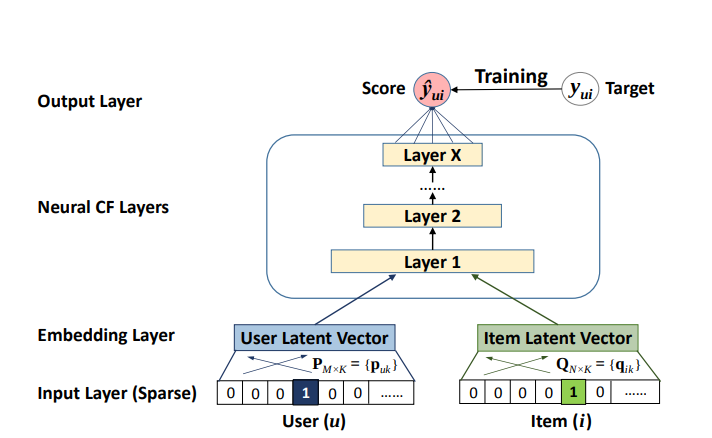

We use a simple architecture displayed above. For more details on embedding layers see upcoming lectures!

In [10]:
class NCF(nn.Module):
    def __init__(self, number_of_users, number_of_movies, embedding_size):
        super().__init__()
        self.embedding_layer_users = nn.Embedding(number_of_users, embedding_size)
        self.embedding_layer_movies = nn.Embedding(number_of_movies, embedding_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(in_features=2 * embedding_size, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1), # maybe predict per category?
            nn.ReLU()
        )

    def forward(self, users, movies):
        users_embedding = self.embedding_layer_users(users)
        movies_embedding = self.embedding_layer_movies(movies)
        concat = torch.cat([users_embedding, movies_embedding], dim=1)
        return torch.squeeze(self.feed_forward(concat))

In [11]:
# Parameters
batch_size = 1024
num_epochs = 25
show_validation_score_every_epochs = 1
embedding_size = 16
learning_rate = 1e-3

In [12]:
def mse_loss(predictions, target):
    return torch.mean((predictions - target) ** 2)

# Build Dataloaders
train_users_torch = torch.tensor(train_users, device=device)
train_movies_torch = torch.tensor(train_movies, device=device)
train_predictions_torch = torch.tensor(train_predictions, device=device)

train_dataloader = DataLoader(
    TensorDataset(train_users_torch, train_movies_torch, train_predictions_torch),
    batch_size=batch_size)

test_users_torch = torch.tensor(test_users, device=device)
test_movies_torch = torch.tensor(test_movies, device=device)

test_dataloader = DataLoader(
    TensorDataset(test_users_torch, test_movies_torch),
    batch_size=batch_size)

ncf = NCF(number_of_users, number_of_movies, embedding_size).to(device)

optimizer = optim.Adam(ncf.parameters(),
                       lr=learning_rate)

In [15]:
# collect losses for qualitative inspection
ncf_logdir = './tensorboard/ncf'
# writer = SummaryWriter(ncf_logdir)

step = 0
with tqdm(total=len(train_dataloader) * num_epochs) as pbar:
    for epoch in range(num_epochs):
        for users_batch, movies_batch, target_predictions_batch in train_dataloader:
            optimizer.zero_grad()

            predictions_batch = ncf(users_batch, movies_batch)

            loss = mse_loss(predictions_batch, target_predictions_batch)

            loss.backward()

            optimizer.step()

            # writer.add_scalar('loss', loss, step)
            pbar.update(1)
            step += 1

        if epoch % show_validation_score_every_epochs == 0:
            
            with torch.no_grad():
                all_predictions = []
                for users_batch, movies_batch in test_dataloader:
                    predictions_batch = ncf(users_batch, movies_batch)
                    all_predictions.append(predictions_batch)
                
            all_predictions = torch.cat(all_predictions)

            reconstuction_rmse = get_score(all_predictions.cpu().numpy())
            pbar.set_description('At epoch {:3d} loss is {:.4f}'.format(epoch, reconstuction_rmse))

            # writer.add_scalar('reconstuction_rmse', reconstuction_rmse, step)

KeyboardInterrupt: 

In [ ]:
# We can visualize the tensorboard logs.
%load_ext tensorboard
%tensorboard --logdir ./tensorboard

To consider:
* Try different layer choices.
* Can we also combine different aforementioned ideas in a neural network?

# Other ideas

Other ideas:
* Differentiable Inference and Generative Models.
* Adapt the loss for the predictions that are the most far off and contribute the most towards the RMSE.
* Graph-based approaches.
* Neighborhood approaches.
* Clustering approaches.
* Many more... Be creative!

----------

[1] Lee, Soojung. "Improving jaccard index for measuring similarity in collaborative filtering." International Conference on Information Science and Applications. Springer, Singapore, 2017.
[2] Liu, Haifeng, et al. "A new user similarity model to improve the accuracy of collaborative filtering." Knowledge-Based Systems 56 (2014): 156-166.



# Getting started with the project

### Google Colab:

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with 
- Zero configuration required
- Free access to GPUs
- Easy sharing

[Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more.

### ETH clusters

ETH provides access to the [Euler](https://scicomp.ethz.ch/wiki/Euler) and [Leonhard](https://scicomp.ethz.ch/wiki/Leonhard) cluster (see also [Getting started with clusters](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys)).

To start:
- Open VPN!
- [Setup SSH keys](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys) (only need to do that once).
- Can even run jupyter-notebooks via [this](https://scicomp.ethz.ch/wiki/Jupyter_on_Euler_and_Leonhard_Open). If you want to run with a GPU may need to change the file accordingly (line 64: "python_cpu/3.6.4" -> "python_gpu/x.x.x" see [this](https://scicomp.ethz.ch/wiki/Python_on_Leonhard) for available versions, line 139 to request a GPU change rusage demands). To see tensorboard results you can mount the remote directory
```
sshfs <ethz-username>@<cluster-hostname>:<directory>
```
and run tensorboard locally 
```
tensorboard --logdir <directory>
```
